# <center>Stock Price Analysis (AAPL - Apple Inc.) </center> 
#  <center> Time Series Forecasting with SARIMA and Prophet</center> 
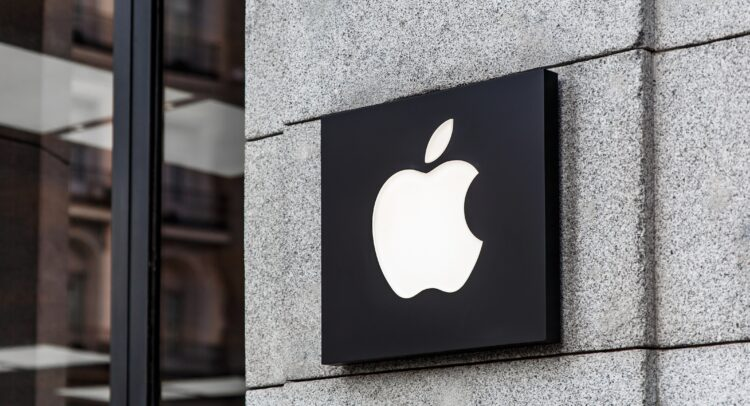

#### Context
In this project, we will study the stock AAPL (the ticker symbol for Apple Inc.). We will use the yfinance API to fetch a dataset of AAPL's historical stock prices over a period of time. This data is typically used for financial analysis, including studying trends in the stock price, predicting future prices, or analyzing the volatility of the stock.
</br></br>

#### Content
- Date: The specific date of the stock prices listed.
- Open: The price at which Apple's stock opened on that particular day.
- High: The highest price Apple’s stock reached during that day.
-Low: The lowest price Apple’s stock reached during that day.
- Close: The price at which Apple's stock closed on that day.
- Adj Close: The adjusted closing price, which reflects the stock's closing price after adjustments for any actions such as dividends or stock splits.
- Volume: The number of shares traded on that particular day.
</br></br>

We will use this dataset to perform analyses with Prophet and ARIMA/SARIMA models to predict future stock prices.

In [1]:
# !pip install prophet
# !pip install yfinance
# !pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

## Import and read time series data

In [3]:
df = yf.download("AAPL", period="5y", interval="1d")
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-09-13,55.000000,55.197498,54.255001,54.687500,52.918037,159053200
2019-09-16,54.432499,55.032501,54.389999,54.974998,53.196220,84632400
2019-09-17,54.990002,55.205002,54.779999,55.174999,53.389767,73274800
2019-09-18,55.264999,55.712502,54.860001,55.692501,53.890514,101360000
2019-09-19,55.502499,55.939999,55.092499,55.240002,53.452671,88242400


In [4]:
df.shape

(1259, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2019-09-13 to 2024-09-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1259 non-null   float64
 1   High       1259 non-null   float64
 2   Low        1259 non-null   float64
 3   Close      1259 non-null   float64
 4   Adj Close  1259 non-null   float64
 5   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


## Data visualization

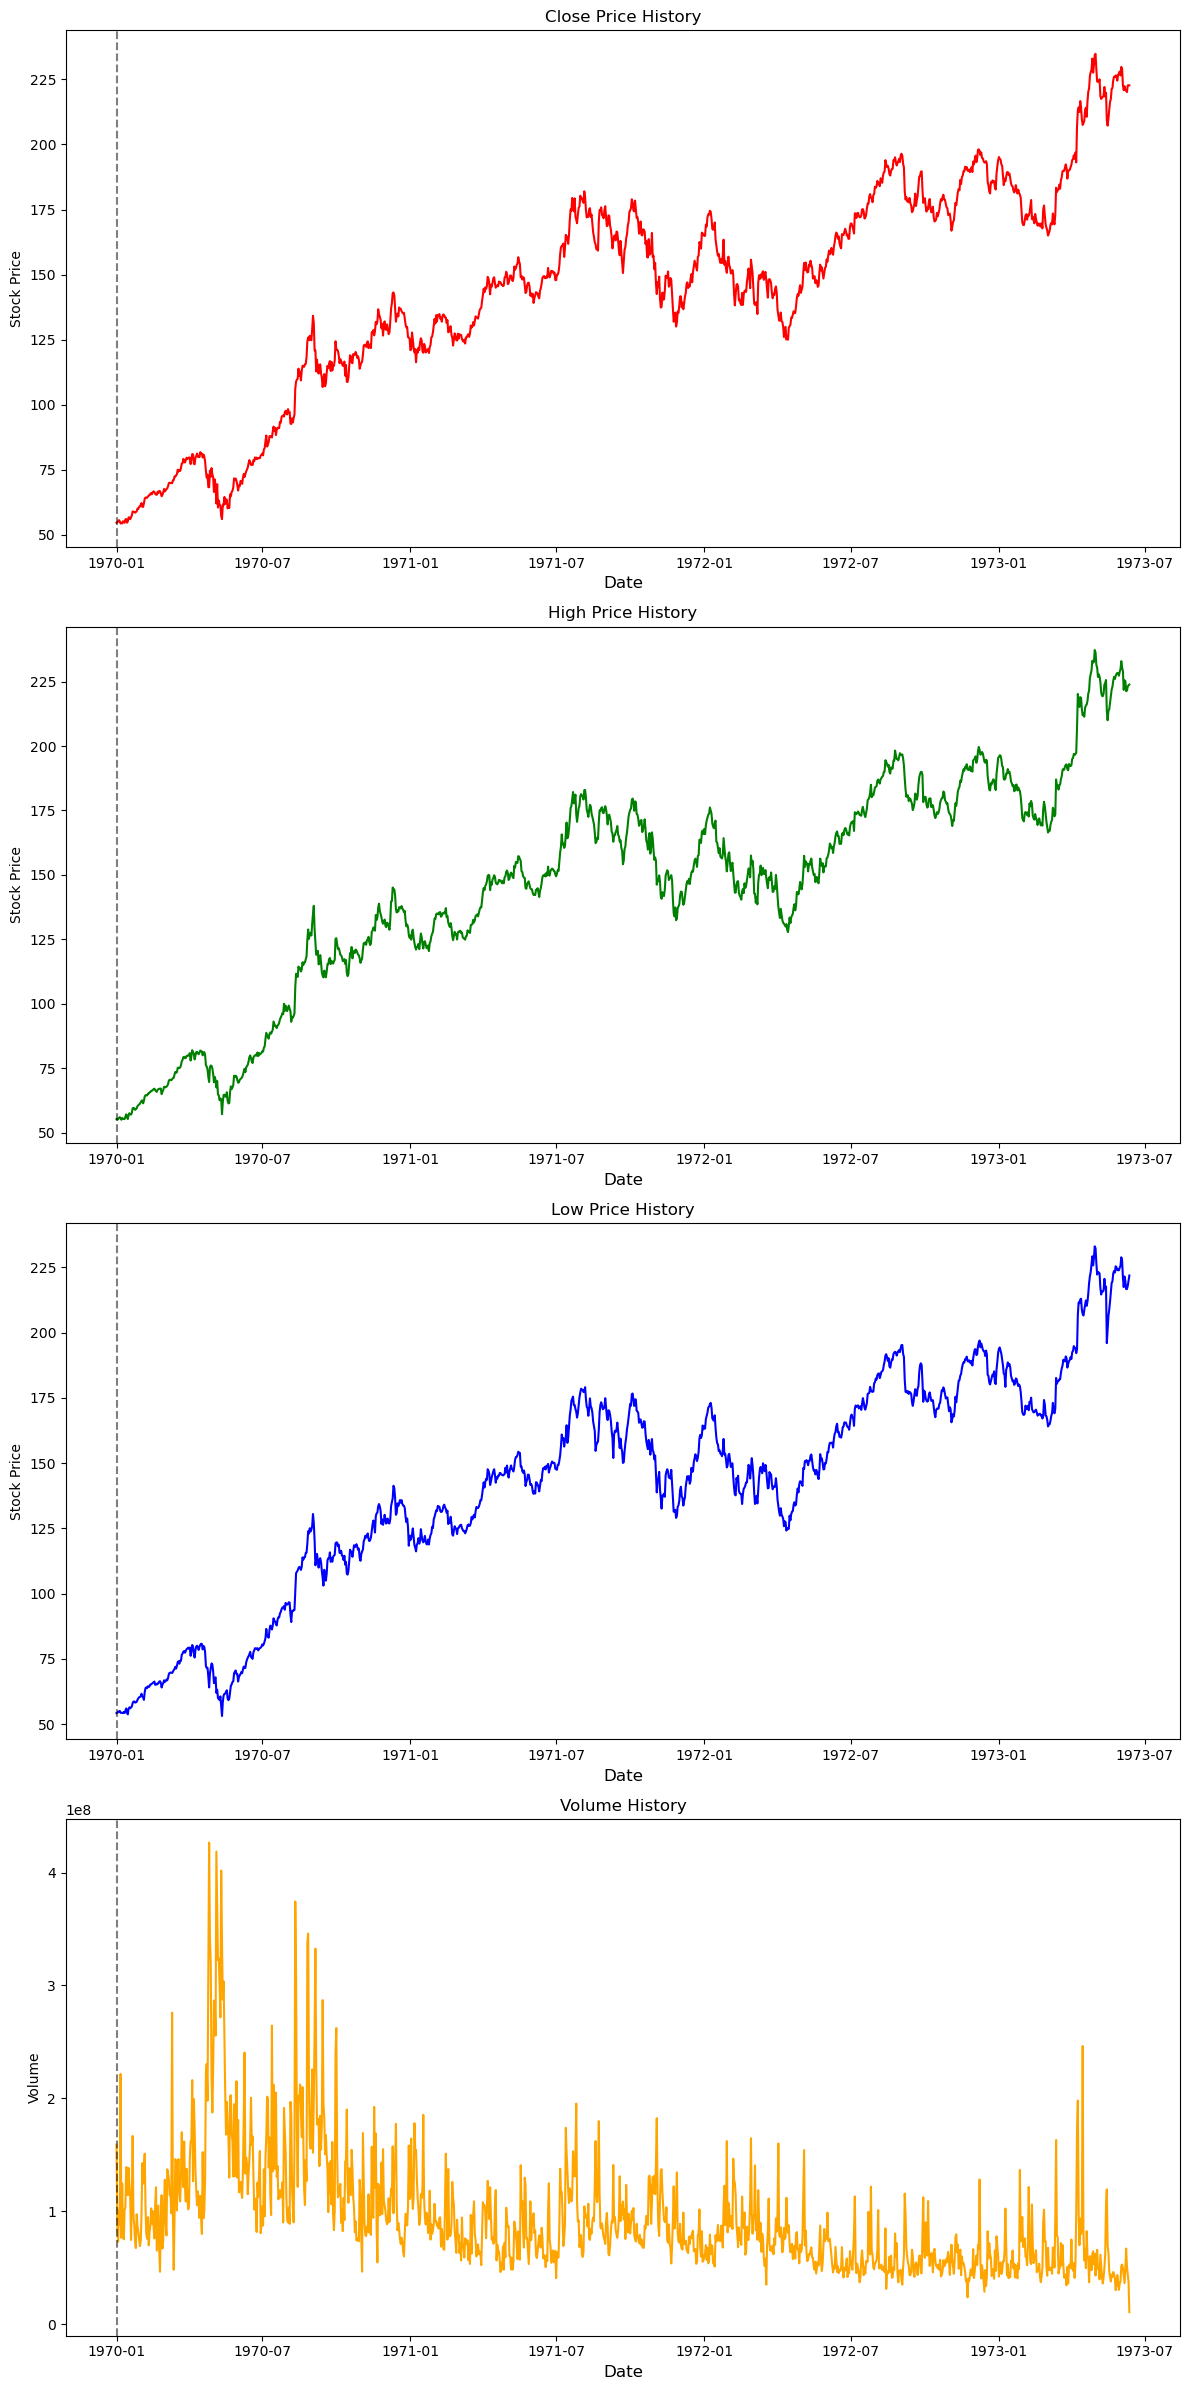

In [34]:
# Create the figure and axes
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 24))

# Close Price Plot
ax1.plot(df.index, df["Close"], color="red")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Close Price History")

# High Price Plot
ax2.plot(df.index, df["High"], color="green")
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Stock Price")
ax2.set_title("High Price History")

# Low Price Plot
ax3.plot(df.index, df["Low"], color="blue")
ax3.set_xlabel("Date", fontsize=12)
ax3.set_ylabel("Stock Price")
ax3.set_title("Low Price History")

# Volume Plot
ax4.plot(df.index, df["Volume"], color="orange")
ax4.set_xlabel("Date", fontsize=12)
ax4.set_ylabel("Volume")
ax4.set_title("Volume History")

# Add vertical lines for each year in all plots
xcoords = pd.date_range(start=df.index.min(), end=df.index.max(), freq='YS')
for xc in xcoords:
    ax1.axvline(x=xc, color='black', linestyle='--', alpha=0.5)
    ax2.axvline(x=xc, color='black', linestyle='--', alpha=0.5)
    ax3.axvline(x=xc, color='black', linestyle='--', alpha=0.5)
    ax4.axvline(x=xc, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Long-term Trends

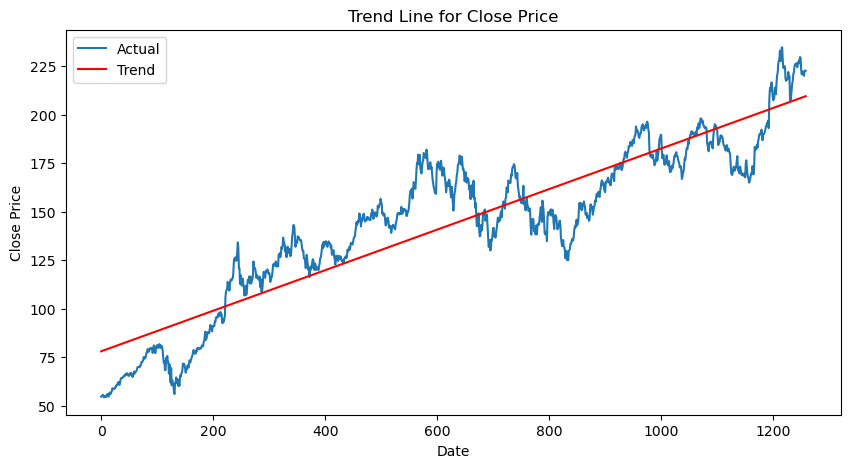

In [35]:
# Linear Regression for Trend Analysis
X = np.arange(len(df)).reshape(-1, 1)  # Time as an independent variable
y = df['Close'].values  # Close price as the dependent variable

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Predict the trend
trend = model.predict(X)

# Plot the actual data and the trend line together
plt.figure(figsize=(10, 5))
plt.plot(df.index, y, label='Actual')
plt.plot(df.index, trend, label='Trend', color='red')
plt.title('Trend Line for Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

## Data Preprocessing
We're likely focusing on analyzing and predicting the "Close" price of the AAPL stock, which represents the final price at which the stock was traded during a particular day. Hence, the other columns—Open, High, Low, Volume, and Adj Close—will be dropped because they are not directly relevant to this specific analysis.

In [8]:
df2 = df[['Close']]
df2.head()

,Close
Date,
2019-09-13,54.687500
2019-09-16,54.974998
2019-09-17,55.174999
2019-09-18,55.692501
2019-09-19,55.240002


## Time decomposition

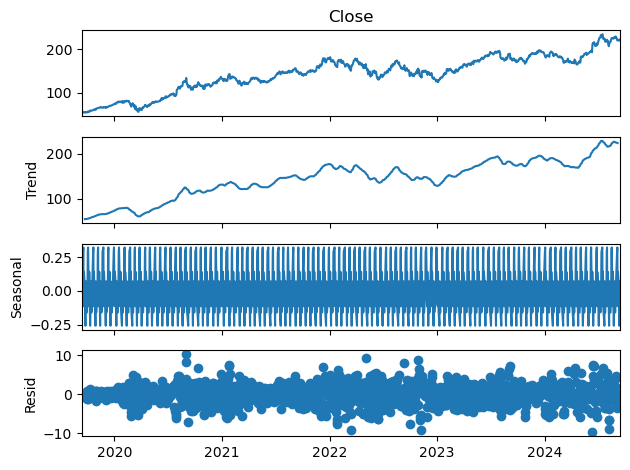

In [36]:
results = seasonal_decompose(df2['Close'], model='additive', period=12)
results.plot()
plt.show()

## Stationarity

In [10]:
df_diff = df2.dropna()
result = adfuller(df_diff)
table = [
    ['ADF Statistic', result[0]],
    ['P-value', result[1]],
    ['Conclusion', 'The time series is stationary' if result[1] < 0.05 else 'The time series is not stationary']
]
print(tabulate(table, headers=['Metrics', 'Value'], tablefmt='github'))

| Metrics       | Value                             |
|---------------|-----------------------------------|
| ADF Statistic | -1.339449255481587                |
| P-value       | 0.6109366502832629                |
| Conclusion    | The time series is not stationary |


In [11]:
from pmdarima.arima.utils import ndiffs
d_value = ndiffs(df2,test = "adf")
print("d value:", d_value)

d value: 1


In [12]:
df_diff = df2.diff().dropna()
result = adfuller(df_diff)
table = [
    ['ADF Statistic', result[0]],
    ['P-value', result[1]],
    ['Conclusion', 'The time series is stationary' if result[1] < 0.05 else 'The time series is not stationary']
]
print(tabulate(table, headers=['Metrics', 'Value'], tablefmt='github'))

| Metrics       | Value                         |
|---------------|-------------------------------|
| ADF Statistic | -36.1205248978035             |
| P-value       | 0.0                           |
| Conclusion    | The time series is stationary |


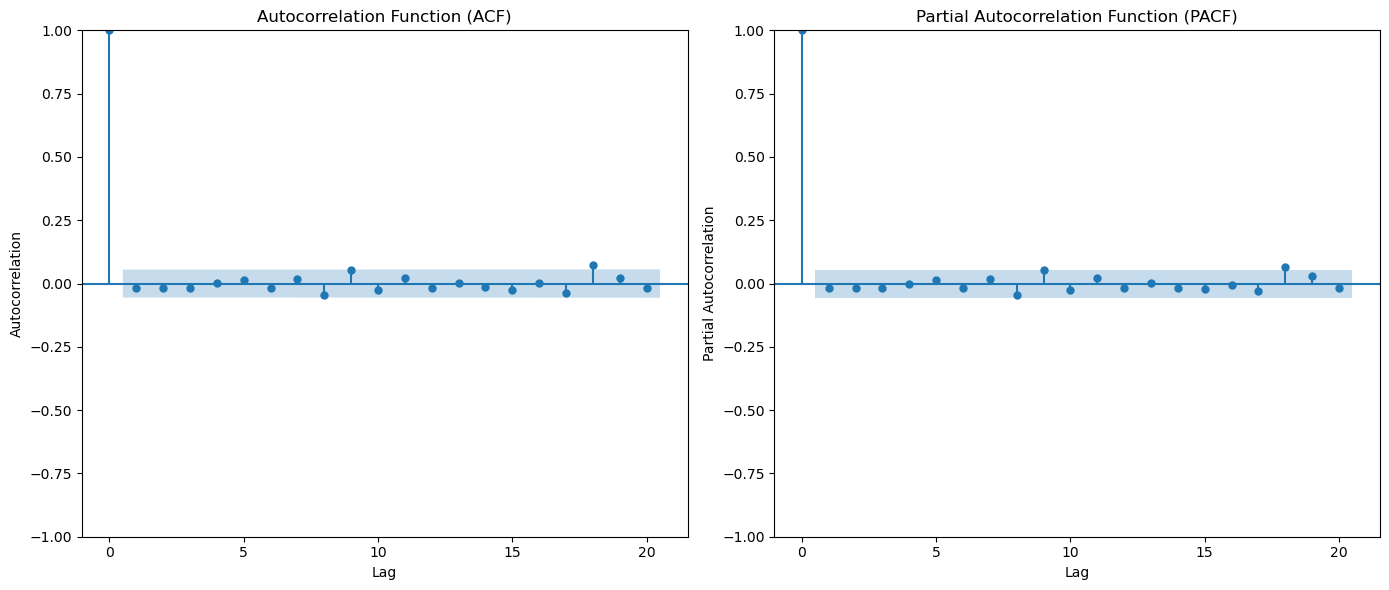

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # Create 1 row, 2 columns

# Plot ACF
plot_acf(df2.Close.diff().dropna(), lags=20, ax=ax[0])  # ACF on the left
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Autocorrelation')
ax[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(df2.Close.diff().dropna(), lags=20, ax=ax[1])  # PACF on the right
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Partial Autocorrelation')
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

## Train / Test Split

In [14]:
split_index = int(len(df2) * 0.8)
df_train = df2.iloc[:split_index]
df_test = df2.iloc[split_index:]
print(len(df_train),len(df_test))

1007 252


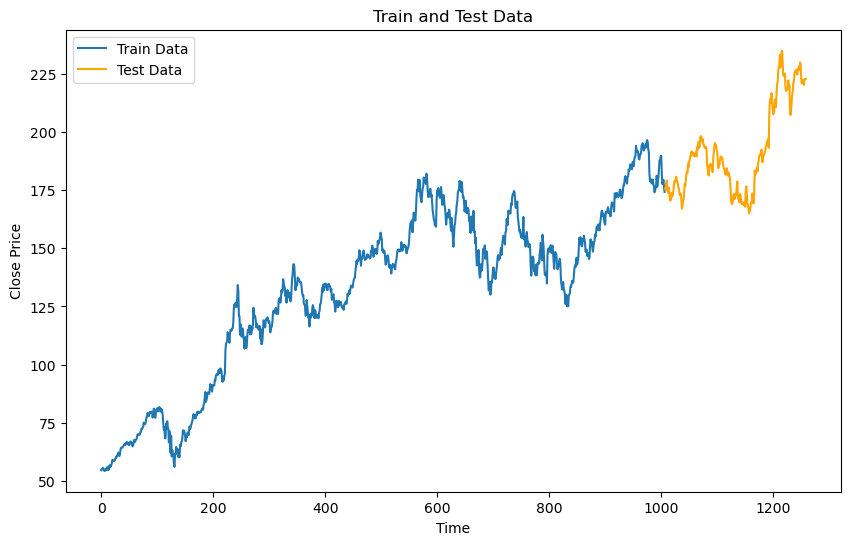

In [15]:
plt.figure(figsize=(10, 6))

# Plot x_train
plt.plot(range(len(df_train)), df_train, label='Train Data')

# Plot x_test
plt.plot(range(len(df_train), len(df_train) + len(df_test)), df_test, label='Test Data', color='orange')

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Train and Test Data')
plt.legend()

plt.show()

## ARIMA

#### Define orders automatically

In [16]:
stepwise_fit = auto_arima(df2,trace=True,suppress_warnings=True)
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5993.461, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5994.987, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5994.968, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5994.736, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5996.392, Time=0.97 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 3.355 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1259
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2994.730
Date:                Fri, 13 Sep 2024   AIC                           5993.461
Time:                        16:44:24   BIC                           6003.735
Sample:                             0   HQIC                          5997.322
               

#### Fit the model

In [17]:
m_arima = sm.tsa.arima.ARIMA(df2, order=stepwise_fit.order)
m_arima = m_arima.fit()
m_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1259
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2996.368
Date:                Fri, 13 Sep 2024   AIC                           5994.736
Time:                        16:44:24   BIC                           5999.874
Sample:                             0   HQIC                          5996.667
                               - 1259                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         6.8608      0.184     37.197      0.000       6.499       7.222
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):               304.81
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.00
Prob(H) (two-sided):                  0.16   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Plot residuals

(array([0.00863911, 0.12094758, 0.02275372, 0.00073007, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00012168]),
 array([-10.58999634,  -4.0622467 ,   2.46550293,   8.99325256,
         15.5210022 ,  22.04875183,  28.57650146,  35.1042511 ,
         41.63200073,  48.15975037,  54.6875    ]),
 <BarContainer object of 10 artists>)

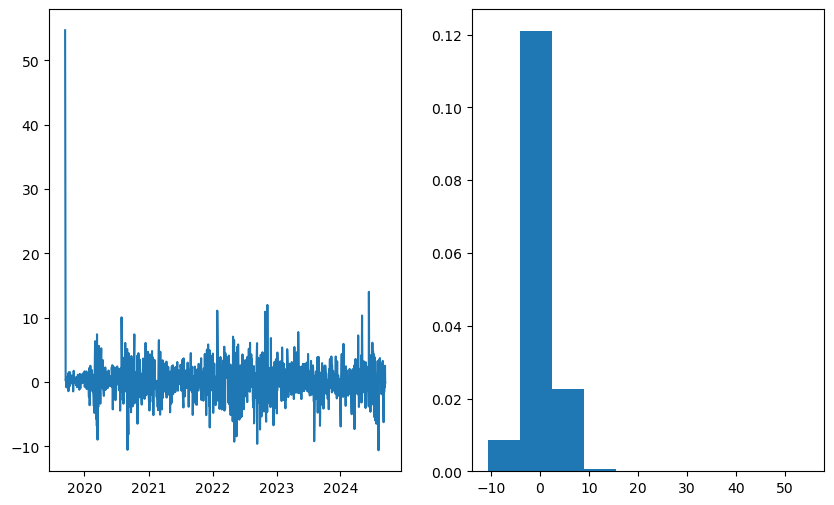

In [18]:
# Get the residuals from the fitted model
residuals = pd.DataFrame(m_arima.resid)

# Create a subplot with 2 plots :  residuals over time and histogral of residuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Plot residuals over time to check for any patterns or trends
ax1.plot(residuals)
ax2.hist(residuals, density=True)

#### Make prediction

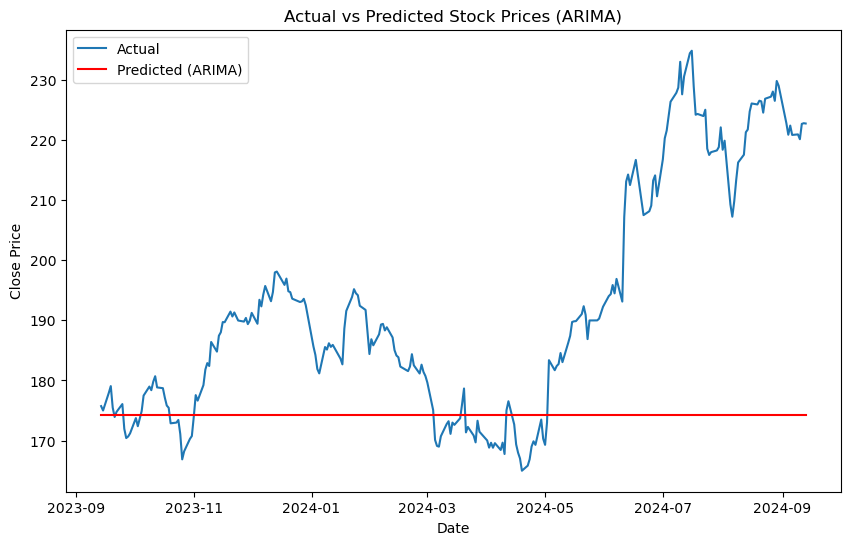

In [19]:
m_arima = sm.tsa.arima.ARIMA(df_train, order=stepwise_fit.order).fit()

# Predict values for the test set
start = len(df_train)
end = len(df_train) + len(df_test) - 1
pred_arima = m_arima.predict(start=start, end=end, typ='levels', dynamic=True)

pred_arima_series = pd.Series(pred_arima.values, index=df_test.index)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))

# Plot the actual test set values
plt.plot(df_test.index, df_test['Close'], label='Actual')

# Plot the predicted values from the ARIMA model
plt.plot(df_test.index, pred_arima_series, label='Predicted (ARIMA)', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Stock Prices (ARIMA)')
plt.legend()

# Show the plot
plt.show()

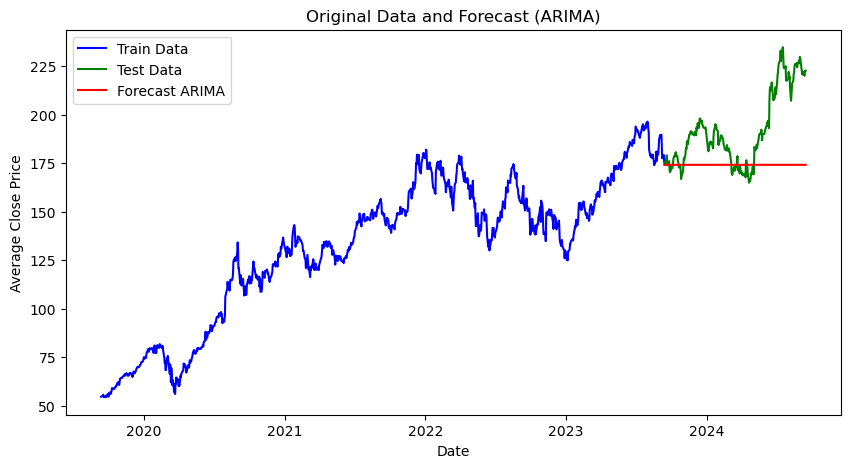

In [20]:
df_fct = df2.copy()
df_fct['fct_arima'] = None # Initialize the column with None values
df_fct.loc[df_test.index, 'fct_arima'] = pred_arima.values

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_train.index, df_train, label='Train Data', color='blue')
plt.plot(df_test.index, df_test, label='Test Data', color='green')
plt.plot(df_fct.index, df_fct['fct_arima'], label='Forecast ARIMA', color='red')

plt.title('Original Data and Forecast (ARIMA)')
plt.ylabel('Average Close Price')
plt.xlabel('Date')
plt.legend()
plt.show()

We have seen that simple ARIMA Model is not suitable for this data (There is seasonality in our data)

## SARIMA

#### Define orders automatically

In [21]:
from pmdarima import auto_arima
smodel = auto_arima(
                    df2,
                    seasonal=True, 
                    m=7,
                    max_p=7, 
                    max_d=1, 
                    max_q=3, 
                    max_P=3, 
                    max_D=1, 
                    max_Q=2,
                    trace=True,
                    error_action='ignore',   # To print the progress of the fitting
                     suppress_warnings=True,  # Ignore potential errors
                     sn_jobs=-1)  # Use all available CPU cores
smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=3.95 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=5993.461, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=5996.571, Time=0.33 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=5996.542, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=5994.736, Time=0.05 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=5994.989, Time=0.21 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=5994.976, Time=0.19 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=5996.844, Time=0.78 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=5994.987, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=5994.968, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=5996.392, Time=0.97 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7] intercept
Total fit time: 7.276 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1259
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2994.730
Date:                Fri, 13 Sep 2024   AIC                           5993.461
Time:                        16:44:33   BIC                           6003.735
Sample:                             0   HQIC                          5997.322
                               - 1259                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1336      0.074      1.811      0.070      -0.011       0.278
sigma2         6.8430      0.184     37.248      0.000       6.483       7.203
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):               304.81
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.00
Prob(H) (two-sided):                  0.17   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Plot residuals

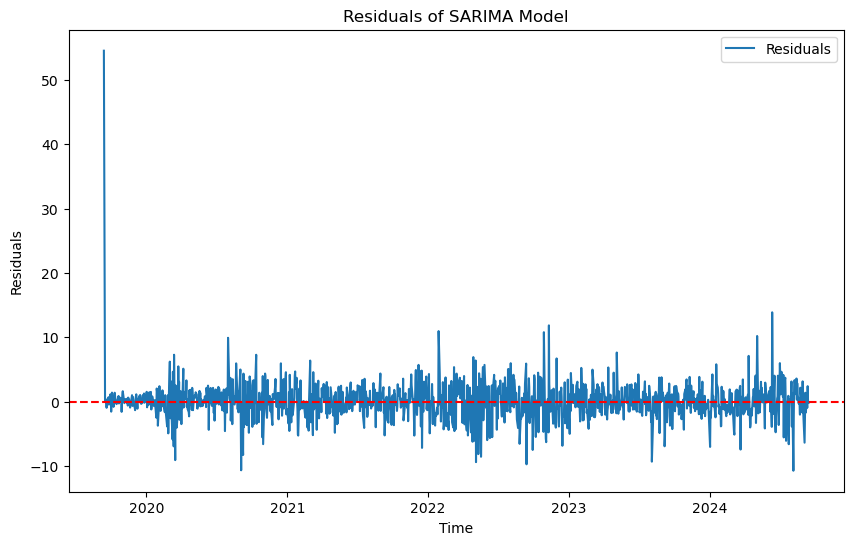

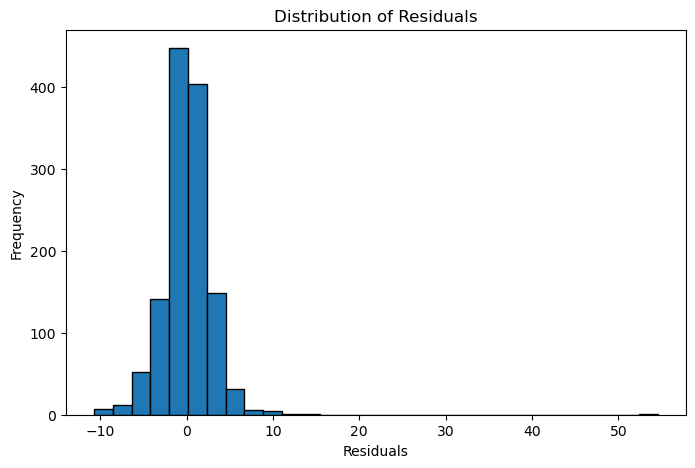

In [41]:
# Get the residuals from the fitted SARIMAX model
residuals = smodel.resid()

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.axhline(0, linestyle='--', color='r')
plt.title('Residuals of SARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Optional: Plot the histogram of residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


#### Make predictions

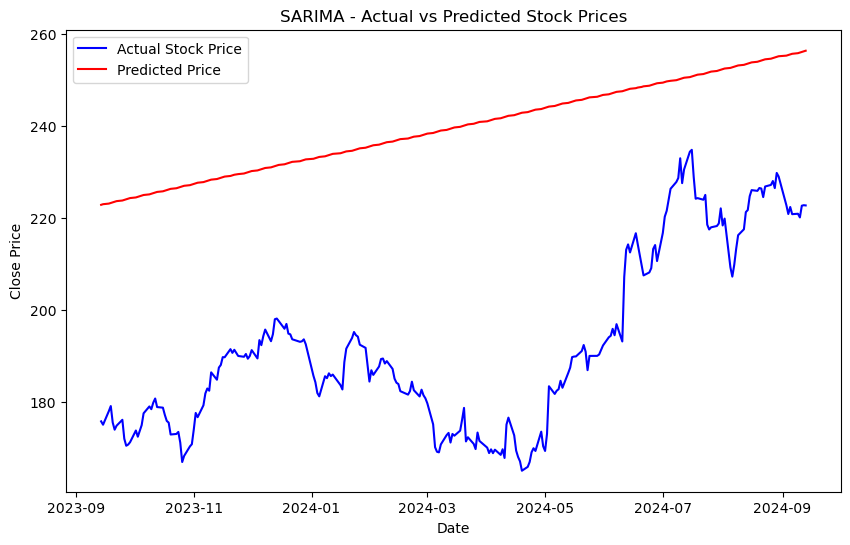

In [43]:
# Make predictions for the test set
start = len(df_train)  # Starting index for predictions (after training set)
end = len(df_train) + len(df_test) - 1  # Ending index for predictions
predictions_sarima = smodel.predict(n_periods=len(df_test))  # Predict test set values

# Create a series for predicted values with the same index as the test data
pred_series = pd.Series(predictions_sarima.values, index=df_test.index)

# Plot actual vs predicted stock prices
plt.figure(figsize=(10, 6))

# Plot actual stock prices from the test set
plt.plot(df_test.index, df_test['Close'], label='Actual Stock Price', color='blue')

# Plot predicted stock prices
plt.plot(df_test.index, pred_series, label='Predicted Price', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SARIMA - Actual vs Predicted Stock Prices')
plt.legend()

# Show the plot
plt.show()

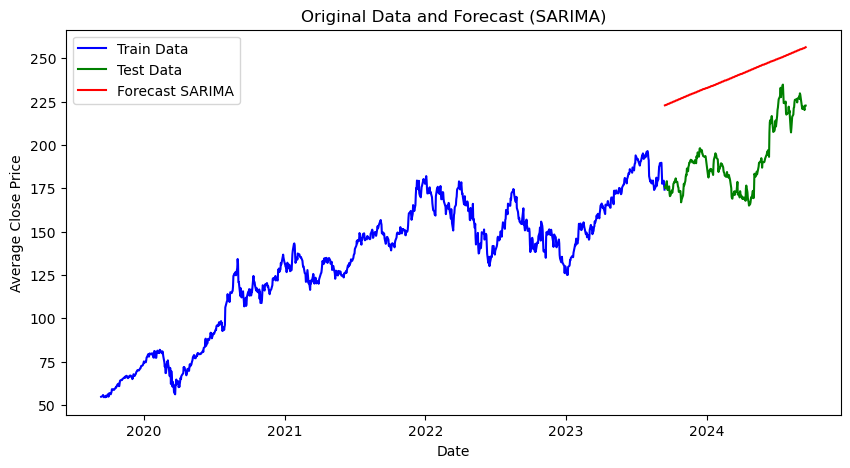

In [24]:
df_fct['fct_sarima'] = None # Initialize the column with None values
df_fct.loc[df_test.index, 'fct_sarima'] = predictions_sarima.values

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_train.index, df_train, label='Train Data', color='blue')
plt.plot(df_test.index, df_test, label='Test Data', color='green')
plt.plot(df_fct.index, df_fct['fct_sarima'], label='Forecast SARIMA', color='red')

plt.title('Original Data and Forecast (SARIMA)')
plt.ylabel('Average Close Price')
plt.xlabel('Date')
plt.legend()
plt.show()

#### Evaluate the SARIMA Model (Rolling cross validation)

In [25]:
# TimeSeriesSplit for rolling cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize lists to store metrics for each fold
mae_sarima_list = []
mape_sarima_list = []
rmse_sarima_list = []

# Rolling cross-validation
for train_index, test_index in tscv.split(df2):
    # Split the data into rolling train and test sets
    train, test = df2.iloc[train_index], df2.iloc[test_index]
    
    # Make predictions on the test set
    predictions = smodel.predict(n_periods=len(test))
    
    # Calculate performance metrics
    mae_sarima = mean_absolute_error(test, predictions)
    mape_sarima = mean_absolute_percentage_error(test, predictions) * 100  # In percentage
    rmse_sarima = np.sqrt(mean_squared_error(test, predictions))
    
    # Append metrics to the respective lists
    mae_sarima_list.append(mae_sarima)
    mape_sarima_list.append(mape_sarima)
    rmse_sarima_list.append(rmse_sarima)

# Calculate average performance metrics across all folds
avg_mae_sarima = np.mean(mae_sarima_list)
avg_mape_sarima = np.mean(mape_sarima_list)
avg_rmse_sarima = np.mean(rmse_sarima_list)

# Print the average metrics
performance = pd.DataFrame({
    'Metrics': ['MAE', 'MAPE', 'RMSE'],
    'SARIMA': [avg_mae_sarima, f'{avg_mape_sarima:.2f}%', avg_rmse_sarima]
})
print(performance.set_index('Metrics'))


            SARIMA
Metrics           
MAE       78.24945
MAPE        53.99%
RMSE     79.505548


## Prophet

In [26]:
# Format data for prophet model using ds and y
# Resetting the index converts the datetime index into a regular column
df_train_prophet = df_train.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
df_test_prophet = df_test.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
df_train_prophet.head()

,ds,y
0,2019-09-13,54.687500
1,2019-09-16,54.974998
2,2019-09-17,55.174999
3,2019-09-18,55.692501
4,2019-09-19,55.240002


##### Fit

In [27]:
%%time
m_prophet = Prophet()
m_prophet.fit(df_train_prophet)

16:44:35 - cmdstanpy - INFO - Chain [1] start processing
16:44:35 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 219 ms
Wall time: 805 ms


##### Generate predictions

In [28]:
fct_prophet = m_prophet.predict(df_test_prophet)
fct_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-09-14,189.878663,183.749021,202.614950,189.878663,189.878663,2.886541,2.886541,2.886541,0.408313,0.408313,0.408313,2.478228,2.478228,2.478228,0.0,0.0,0.0,192.765204
1,2023-09-15,190.048372,183.467031,201.707395,190.048372,190.048372,2.338516,2.338516,2.338516,0.329974,0.329974,0.329974,2.008542,2.008542,2.008542,0.0,0.0,0.0,192.386888
2,2023-09-18,190.557500,182.464109,200.656998,190.557500,190.557500,1.287183,1.287183,1.287183,0.626677,0.626677,0.626677,0.660506,0.660506,0.660506,0.0,0.0,0.0,191.844683
3,2023-09-19,190.727210,181.190579,200.886495,190.727210,190.727210,0.665632,0.665632,0.665632,0.422922,0.422922,0.422922,0.242710,0.242710,0.242710,0.0,0.0,0.0,191.392842
4,2023-09-20,190.896919,180.983823,200.903661,190.896919,190.896919,0.340034,0.340034,0.340034,0.494153,0.494153,0.494153,-0.154119,-0.154119,-0.154119,0.0,0.0,0.0,191.236953


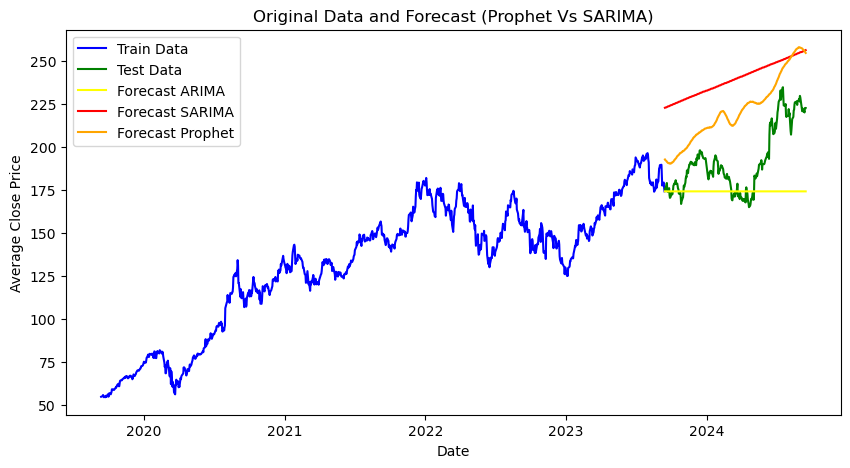

In [47]:
df_fct['fct_prophet'] = None # Initialize the column with None values
df_fct.loc[df_test.index, 'fct_prophet'] = fct_prophet['yhat'].values

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_train.index, df_train, label='Train Data', color='blue')
plt.plot(df_test.index, df_test, label='Test Data', color='green')
plt.plot(df_fct.index, df_fct['fct_arima'], label='Forecast ARIMA', color='yellow')
plt.plot(df_fct.index, df_fct['fct_sarima'], label='Forecast SARIMA', color='red')
plt.plot(df_fct.index, df_fct['fct_prophet'], label='Forecast Prophet', color='orange')

plt.title('Original Data and Forecast (Prophet Vs SARIMA)')
plt.ylabel('Average Close Price')
plt.xlabel('Date')
plt.legend()
plt.show()

#### Evaluate the prophet model (Cross validation)

In [30]:
df_prophet = df.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
df_prophet.head()

,ds,Open,High,Low,y,Adj Close,Volume
0,2019-09-13,55.000000,55.197498,54.255001,54.687500,52.918037,159053200
1,2019-09-16,54.432499,55.032501,54.389999,54.974998,53.196220,84632400
2,2019-09-17,54.990002,55.205002,54.779999,55.174999,53.389767,73274800
3,2019-09-18,55.264999,55.712502,54.860001,55.692501,53.890514,101360000
4,2019-09-19,55.502499,55.939999,55.092499,55.240002,53.452671,88242400


In [31]:
m = Prophet().fit(df_prophet)
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days')
df_cv.head()

16:44:36 - cmdstanpy - INFO - Chain [1] start processing
16:44:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

16:44:37 - cmdstanpy - INFO - Chain [1] start processing
16:44:37 - cmdstanpy - INFO - Chain [1] done processing
16:44:37 - cmdstanpy - INFO - Chain [1] start processing
16:44:37 - cmdstanpy - INFO - Chain [1] done processing
16:44:38 - cmdstanpy - INFO - Chain [1] start processing
16:44:38 - cmdstanpy - INFO - Chain [1] done processing
16:44:38 - cmdstanpy - INFO - Chain [1] start processing
16:44:38 - cmdstanpy - INFO - Chain [1] done processing
16:44:39 - cmdstanpy - INFO - Chain [1] start processing
16:44:39 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-09-27,142.549649,138.451298,146.689311,145.369995,2021-09-24
1,2021-09-28,142.787900,138.502336,146.827707,141.910004,2021-09-24
2,2021-09-29,142.966904,138.707168,147.102791,142.830002,2021-09-24
3,2021-09-30,143.059501,138.818780,147.396537,141.500000,2021-09-24
4,2021-10-01,143.124203,138.795730,146.999370,142.649994,2021-09-24


## Comparison of metrics between SARIMA and Prophet models

In [32]:
mae_prophet = mean_absolute_error(y_true=df_cv['y'],
                   y_pred=df_cv['yhat'])
mape_prophet = mean_absolute_percentage_error(y_true=df_cv['y'],
                   y_pred=df_cv['yhat'])*100
rmse_prophet = np.sqrt(mean_squared_error(y_true=df_cv['y'],
                   y_pred=df_cv['yhat']))

performance = pd.DataFrame({
    'Metrics': ['MAE', 'MAPE', 'RMSE'],
    'SARIMA': [avg_mae_sarima, f'{avg_mape_sarima:.2f}%', avg_rmse_sarima],
    'Prophet': [mae_prophet, f'{mape_prophet:.2f}%', rmse_prophet],
})

print(performance.set_index('Metrics'))

            SARIMA    Prophet
Metrics                      
MAE       78.24945  36.416227
MAPE        53.99%     21.75%
RMSE     79.505548  43.124831


#### ✨ The more effective model is the one with the lower MAPE : PROPHET ✨

## Forecast for 2 years with the best model

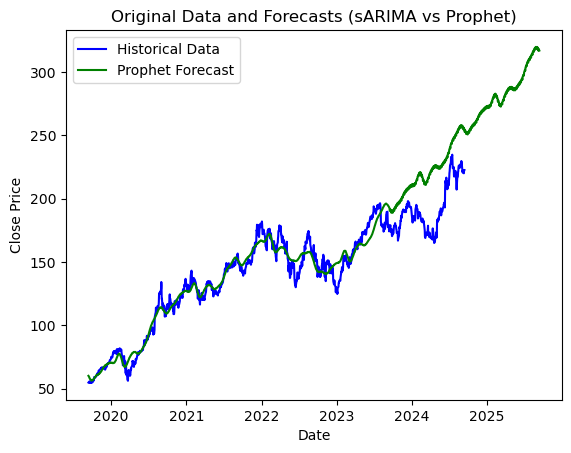

In [48]:
steps = 2 * 365   # Number of steps to forecast (daily data)
df = df.reset_index() # Reset index

# Create future dataframe and predict
future_prophet = m_prophet.make_future_dataframe(periods=steps, freq='D')
prophet_forecast = m_prophet.predict(future_prophet)

# Plot
plt.plot(df2.index, df2['Close'], label='Historical Data', color='blue')
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Prophet Forecast', color='green')

plt.title('Original Data and Forecasts (sARIMA vs Prophet)')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.legend()
plt.show()